<a href="https://colab.research.google.com/github/rajashekar028/FaceEmotionRecognition/blob/main/FaceEmotionRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
### CNN models ###
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D,concatenate
from keras.models import Model
from tensorflow.keras import layers
from keras.applications.inception_v3 import InceptionV3


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/fer2013.csv')

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
# parameters
batch_size = 32
num_epochs = 10
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
base_path = 'models/'
shape_x = 48
shape_y = 48
image_size=(48,48)

In [ ]:
# Preprocessing
data['pixels']=data['pixels'].astype("string")
pixels = data['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.strip().split(' ',48*48)]
    face = np.asarray(face).reshape(width, height)
    face = cv2.resize(face.astype('uint8'),image_size)
    faces.append(face.astype('float32'))
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
faces /= 127.5
faces -= 1.
emotions = pd.get_dummies(data['emotion']).to_numpy()

In [ ]:
# data augmentation
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

In [ ]:
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.3,shuffle=True)
xval,xtest,yval,ytest=train_test_split(xtest,ytest,test_size=0.3,shuffle=True)

# Xception model:

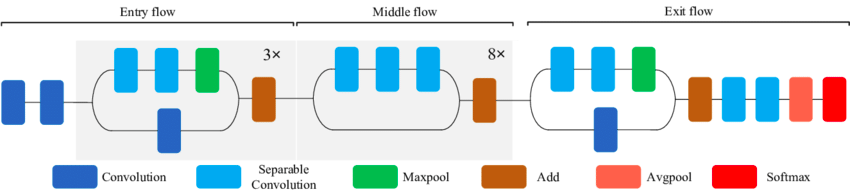

In [ ]:
def entry_flow(inputs) :
  
    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    previous_block_activation = x
    
    for size in [64, 128, 256] :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        
        x = keras.layers.Add()([x, residual])
        previous_block_activation = x
    
    return x

In [ ]:
def middle_flow(x, num_blocks=8) :
    
    previous_block_activation = x
    
    for _ in range(num_blocks) :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    
    return x


In [ ]:
def exit_flow(x, num_classes=7) :
    
    previous_block_activation = x
    
    x = Activation('relu')(x)
    x = SeparableConv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])
      
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    return x


In [ ]:

inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))

In [ ]:
xception = Model(inputs, outputs,name="Xception")

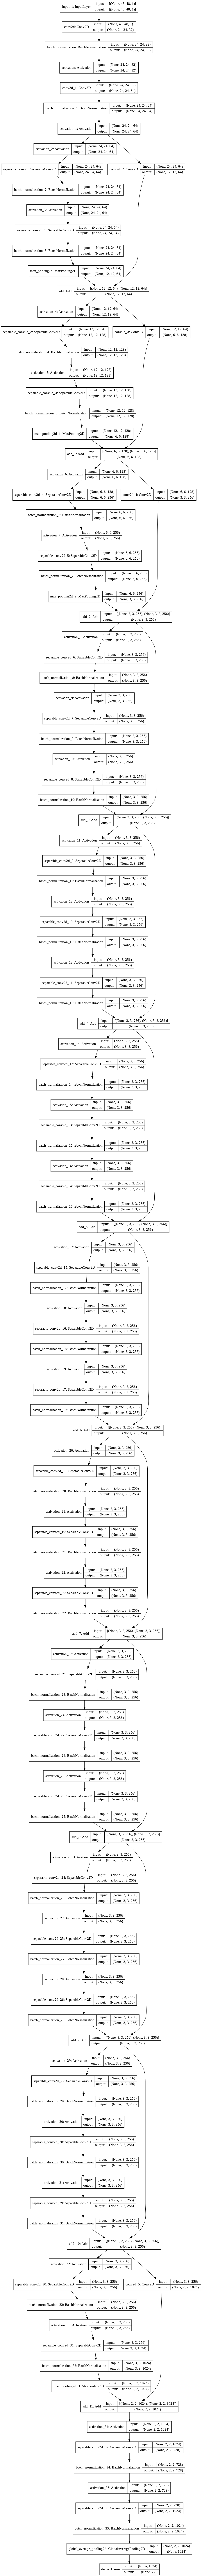

In [ ]:
plot_model(xception, to_file='xception.png', show_shapes=True, show_layer_names=True)

In [ ]:
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
xception.summary()

Model: "Xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 24, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 24, 24, 32)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

# Dexpression

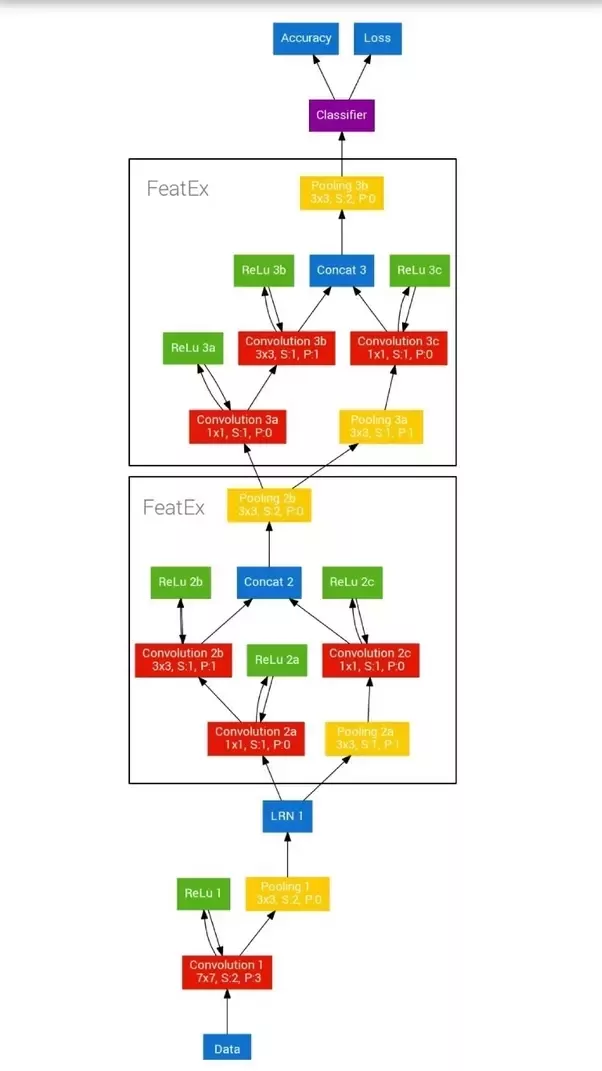

In [ ]:
def dexpression():
    inputs = Input(shape=(shape_x, shape_y, 1))

    x = Conv2D(64, 7, strides = 2, padding='same')(inputs)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)

    x_1 = Conv2D(96, 1, strides = 1, padding='same')(x)
    x_1 = Activation('relu')(x_1)
    x_1 = MaxPooling2D(3, strides=1, padding='same')(x_1)
    x_1 = BatchNormalization()(x_1)

    x_2 = Conv2D(208, 3, strides = 1, padding='same')(x_1)
    x_2 = Activation('relu')(x_2)
    x_2 = MaxPooling2D(3, strides=1, padding='same')(x_2)

    x_3 = Conv2D(64, 1, strides = 1, padding='same')(x_1)
    x_3 = Activation('relu')(x_3)
    x_3 = MaxPooling2D(3, strides=1, padding='same')(x_3)


    x_4=concatenate([x_2,x_3],axis=3)

    x_5 = Conv2D(96, 1, strides = 1, padding='same')(x_4)
    x_5 = Activation('relu')(x_5)
    x_5 = Conv2D(208, 3, strides = 1, padding='same')(x_5)
    x_5 = Activation('relu')(x_5)

    x_6 = MaxPooling2D(3, strides=1, padding='same')(x_4)
    x_6 = Activation('relu')(x_6)
    x_6 = Conv2D(64, 1, strides = 1, padding='same')(x_6)
    x_6 = Activation('relu')(x_6)
    x_6 = MaxPooling2D(3, strides=1, padding='same')(x_6)
    x_7 = concatenate([x_5,x_6],axis=3)

    x_8 = Flatten()(x_7)
    x_8 = Dropout(0.25)(x_8)
    x_8 = Dense(7, activation='softmax')(x_8)
    return Model(inputs, x_8,name='DeXpression')

In [ ]:
dexpression=dexpression()

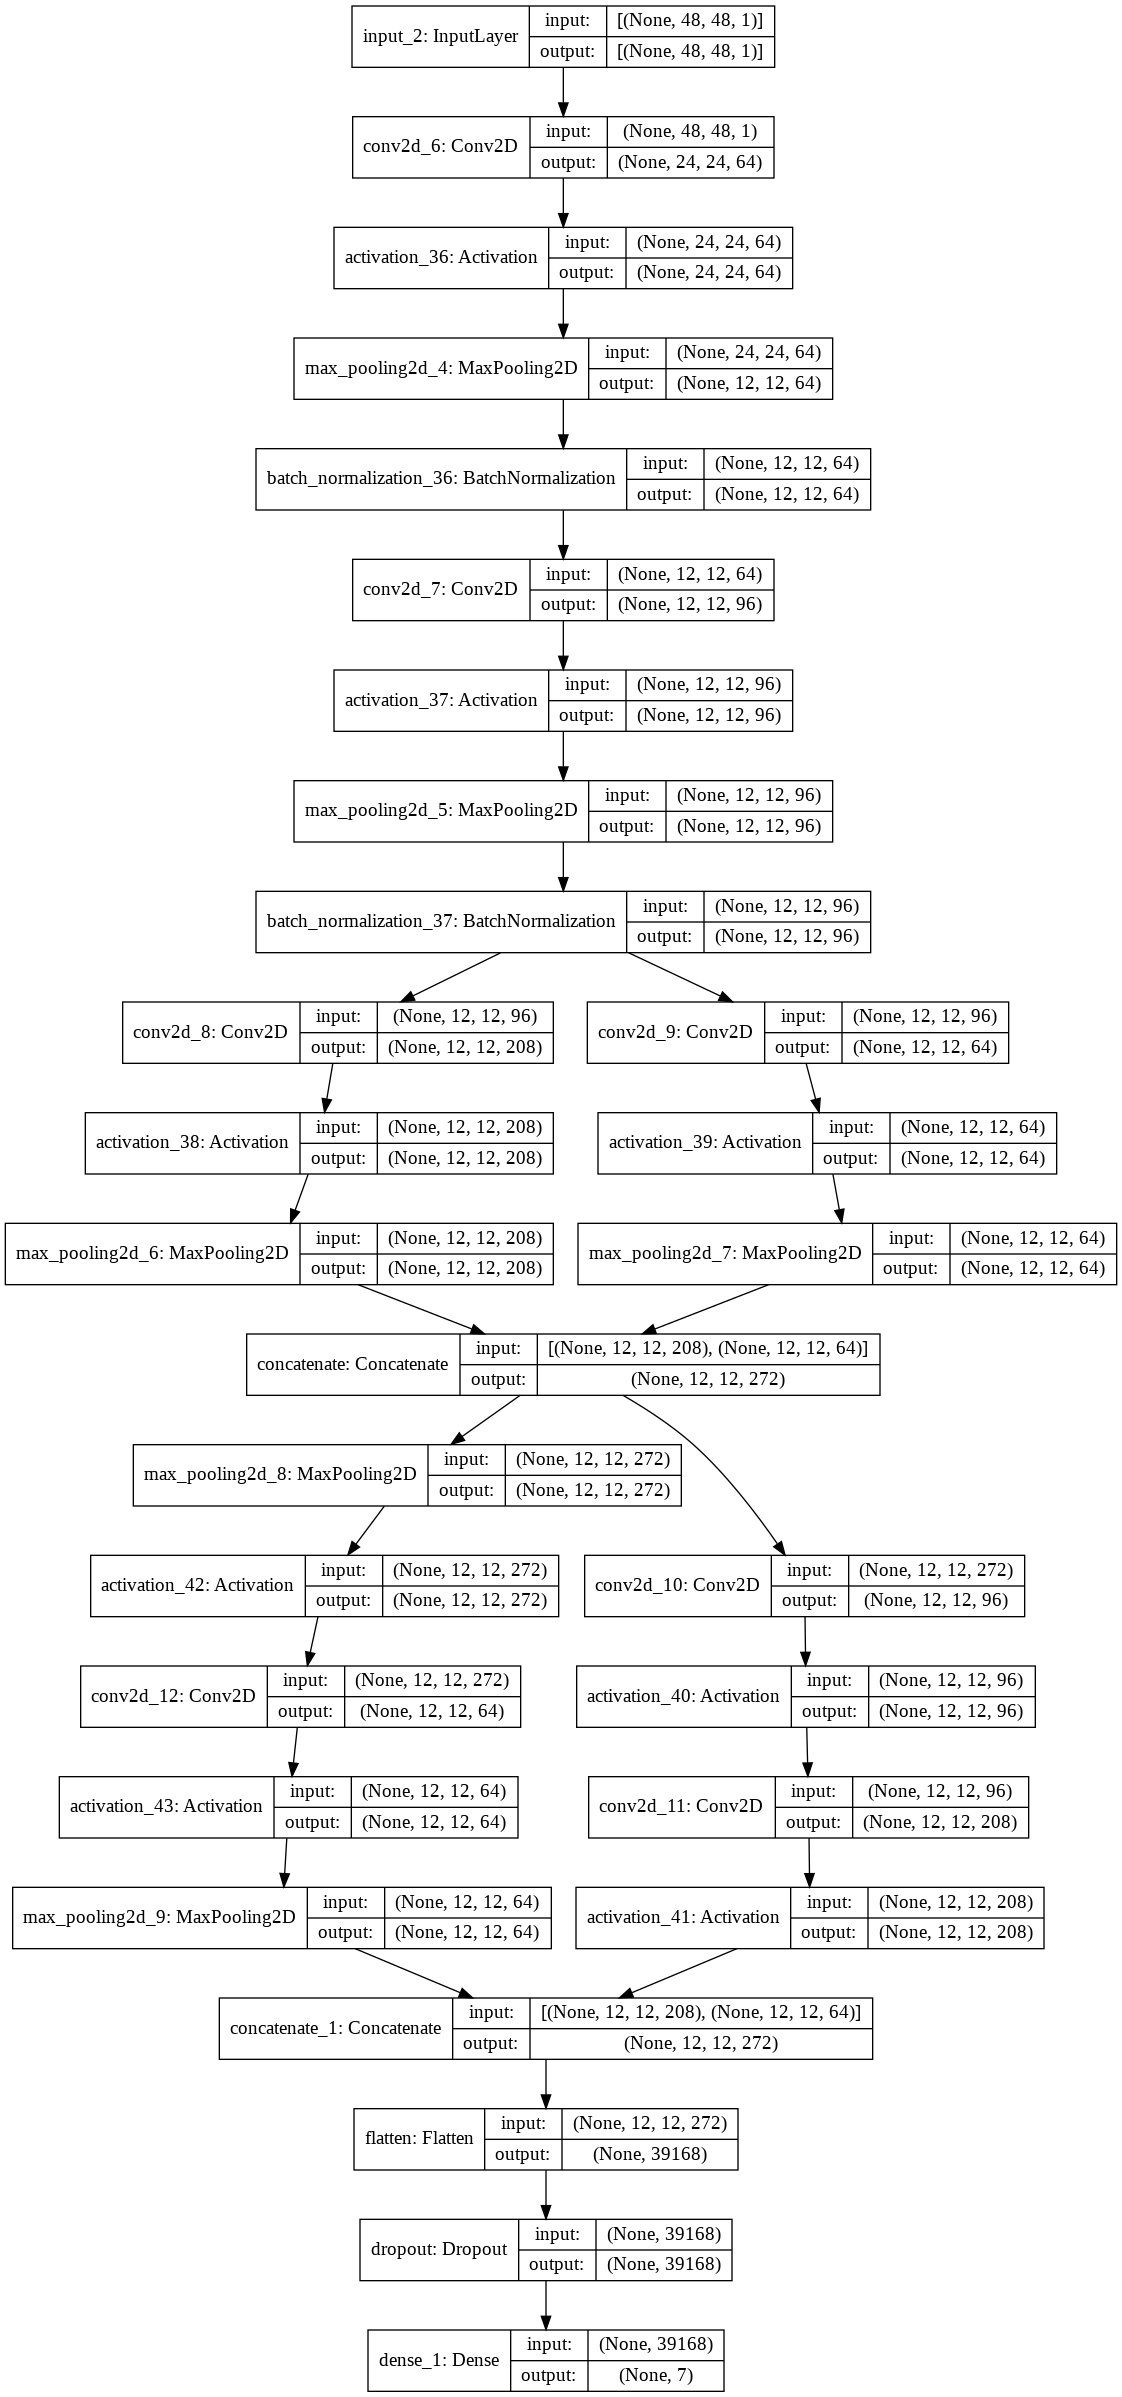

In [ ]:
plot_model(dexpression, to_file='dexpression.png', show_shapes=True, show_layer_names=True)

In [ ]:
dexpression.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dexpression.summary()

Model: "DeXpression"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 24, 24, 64)   3200        input_2[0][0]                    
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 24, 24, 64)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 12, 12, 64)   0           activation_36[0][0]              
________________________________________________________________________________________

# CNN
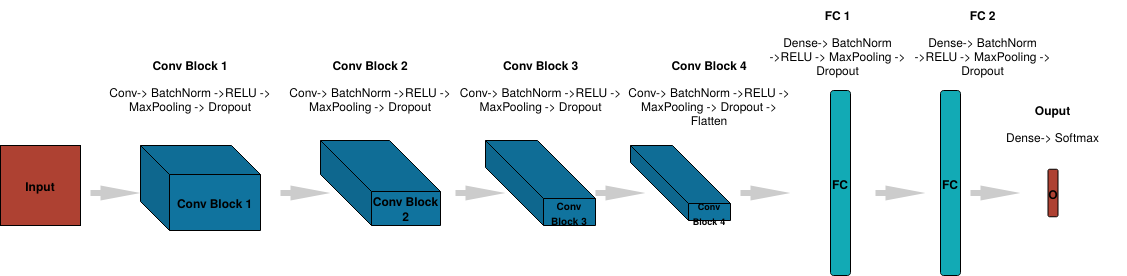

In [ ]:


def CNN():
    model = Sequential(name='CNN')
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    return model



In [ ]:
CNN=CNN()

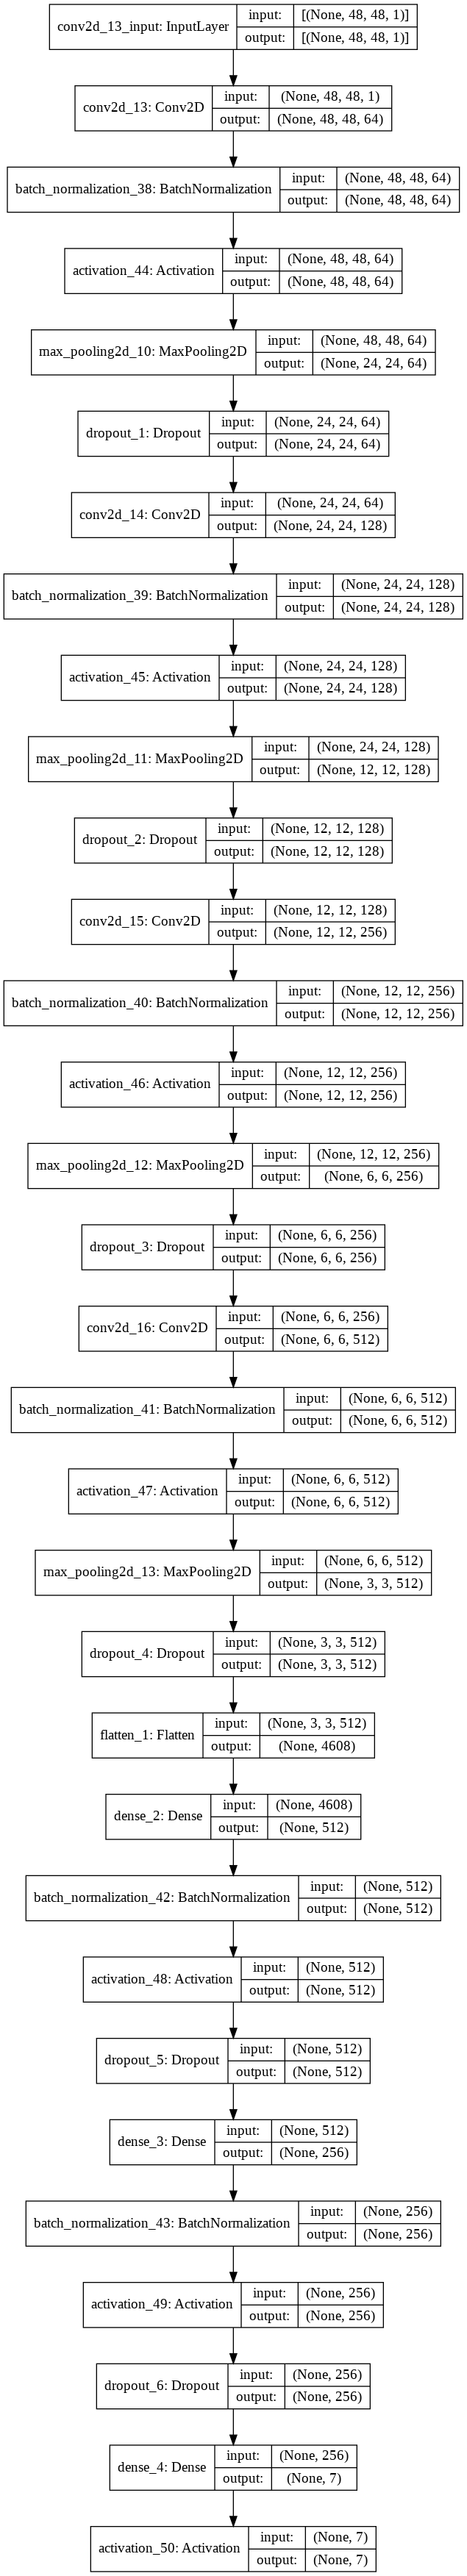

In [ ]:
plot_model(CNN, to_file='CNN.png', show_shapes=True, show_layer_names=True)

In [ ]:
CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
CNN.summary()


Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_38 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_44 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_39 (Batc (None, 24, 24, 128)       512     

# Training

# Xception

In [ ]:


early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=50, min_lr=0.00001,model='auto')
trained_models_path = base_path + '_Xception'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]



In [ ]:
xception_history =xception.fit(datagen.flow(xtrain, ytrain, batch_size),
          steps_per_epoch=len(xtrain) / batch_size, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(xval,yval))

Epoch 1/10
785/785 [==============================] - 501s 623ms/step - loss: 1.7496 - accuracy: 0.2975 - val_loss: 4.6815 - val_accuracy: 0.1205

Epoch 00001: val_loss improved from inf to 4.68152, saving model to models/_Xception.01-0.12.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
785/785 [==============================] - 491s 626ms/step - loss: 1.4743 - accuracy: 0.4279 - val_loss: 1.5549 - val_accuracy: 0.4339

Epoch 00002: val_loss improved from 4.68152 to 1.55492, saving model to models/_Xception.02-0.43.hdf5
Epoch 3/10
785/785 [==============================] - 489s 623ms/step - loss: 1.3743 - accuracy: 0.4680 - val_loss: 2.6182 - val_accuracy: 0.2877

Epoch 00003: val_loss did not improve from 1.55492
Epoch 4/10
785/785 [==============================] - 493s 628ms/step - loss: 1.3110 - accuracy: 0.4997 - val_loss: 1.5311 - val_accuracy: 0.4364

Epoch 00004: val_loss improved from 1.55492 to 1.53107, saving model to models/_Xception.04-0.44.hdf5
Epoch 5/10
785/785 [==============================] - 490s 624ms/step - loss: 1.2670 - accuracy: 0.5178 - val_loss: 1.3082 - val_accuracy: 0.4777

Epoch 00005: val_loss improved from 1.53107 to 1.30818, saving model to models/_Xception.05-0.48.hdf5
Epoch 6/10
785/785 [==============================] - 4

# Dexpression

In [ ]:


early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=25, min_lr=0.00001,model='auto')
trained_models_path = base_path + '_DeXpression'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]



In [ ]:
dexpression_history =dexpression.fit(datagen.flow(xtrain, ytrain, batch_size),
          steps_per_epoch=len(xtrain) / batch_size, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(xval,yval))

Epoch 1/10
785/785 [==============================] - 365s 462ms/step - loss: 2.0049 - accuracy: 0.2475 - val_loss: 1.6670 - val_accuracy: 0.3169

Epoch 00001: val_loss improved from inf to 1.66703, saving model to models/_DeXpression.01-0.32.hdf5
Epoch 2/10
785/785 [==============================] - 363s 462ms/step - loss: 1.6957 - accuracy: 0.3204 - val_loss: 1.5417 - val_accuracy: 0.3948

Epoch 00002: val_loss improved from 1.66703 to 1.54167, saving model to models/_DeXpression.02-0.39.hdf5
Epoch 3/10
785/785 [==============================] - 364s 463ms/step - loss: 1.5856 - accuracy: 0.3798 - val_loss: 1.4651 - val_accuracy: 0.4277

Epoch 00003: val_loss improved from 1.54167 to 1.46508, saving model to models/_DeXpression.03-0.43.hdf5
Epoch 4/10
785/785 [==============================] - 363s 462ms/step - loss: 1.5164 - accuracy: 0.4075 - val_loss: 1.4416 - val_accuracy: 0.4501

Epoch 00004: val_loss improved from 1.46508 to 1.44158, saving model to models/_DeXpression.04-0.45.h

# CNN

In [ ]:
early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=25, min_lr=0.00001,model='auto')
trained_models_path = base_path + 'CNN'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]


In [ ]:
CNN_history =CNN.fit(datagen.flow(xtrain, ytrain, batch_size),
          steps_per_epoch=len(xtrain) / batch_size, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(xval,yval))

Epoch 1/10
785/785 [==============================] - 662s 818ms/step - loss: 1.9426 - accuracy: 0.2441 - val_loss: 1.7105 - val_accuracy: 0.3506

Epoch 00001: val_loss improved from inf to 1.71052, saving model to models/CNN.01-0.35.hdf5
Epoch 2/10
785/785 [==============================] - 636s 810ms/step - loss: 1.6119 - accuracy: 0.3706 - val_loss: 1.4366 - val_accuracy: 0.4522

Epoch 00002: val_loss improved from 1.71052 to 1.43655, saving model to models/CNN.02-0.45.hdf5
Epoch 3/10
785/785 [==============================] - 637s 812ms/step - loss: 1.4449 - accuracy: 0.4329 - val_loss: 1.2499 - val_accuracy: 0.5264

Epoch 00003: val_loss improved from 1.43655 to 1.24994, saving model to models/CNN.03-0.53.hdf5
Epoch 4/10
785/785 [==============================] - 638s 813ms/step - loss: 1.3706 - accuracy: 0.4729 - val_loss: 1.2215 - val_accuracy: 0.5322

Epoch 00004: val_loss improved from 1.24994 to 1.22153, saving model to models/CNN.04-0.53.hdf5
Epoch 5/10
785/785 [============

# Testing

# Plotting accuracy and loss curves

In [ ]:
fig,axes=plt.subplots(3,2,figsize=(20, 20))
for (m,history), ax in zip({'CNN':CNN_history,'Xception':xception_history,'Dexpression':dexpression_history}.items(),axes):
    # Loss Curves
    
    ax[0].plot(history.history['loss'],'r',linewidth=2.0)
    ax[0].plot(history.history['val_loss'],'b',linewidth=2.0)
    ax[0].legend(['Training loss', 'Validation Loss'],fontsize=18)
    ax[0].set_xlabel('Epochs ',fontsize=16)
    ax[0].set_ylabel('Loss',fontsize=16)
    ax[0].set_title('Loss Curves '+m,fontsize=16)
 
    # Accuracy Curves
    ax[1].plot(history.history['accuracy'],'r',linewidth=2.0)
    ax[1].plot(history.history['val_accuracy'],'b',linewidth=2.0)
    ax[1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    ax[1].set_xlabel('Epochs ',fontsize=16)
    ax[1].set_ylabel('Accuracy',fontsize=16)
    ax[1].set_title('Accuracy Curves '+m,fontsize=16)

In [ ]:
plt.savefig('plots.png')

<Figure size 432x288 with 0 Axes>


# Classification reports

In [ ]:

for model in [CNN,xception,dexpression]:
    ypred=model.predict(xtest)
    ypred_=np.argmax(ypred, axis=1)
    ytest_=np.argmax(ytest, axis=1)
    print(classification_report(ytest_, ypred_,digits=3))
  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.167     0.002     0.004       462
           1      0.020     0.352     0.037        54
           2      0.000     0.000     0.000       476
           3      0.248     0.674     0.362       815
           4      0.262     0.021     0.039       526
           5      0.000     0.000     0.000       335
           6      1.000     0.002     0.004       563

    accuracy                          0.180      3231
   macro avg      0.242     0.150     0.064      3231
weighted avg      0.304     0.180     0.100      3231

              precision    recall  f1-score   support

           0      0.140     0.316     0.194       462
           1      0.000     0.000     0.000        54
           2      0.176     0.006     0.012       476
           3      0.250     0.071     0.111       815
           4      0.167     0.002     0.004       526
           5      0.000     0.000     0.000       335
           6      0.168 

# Confusion Matrix

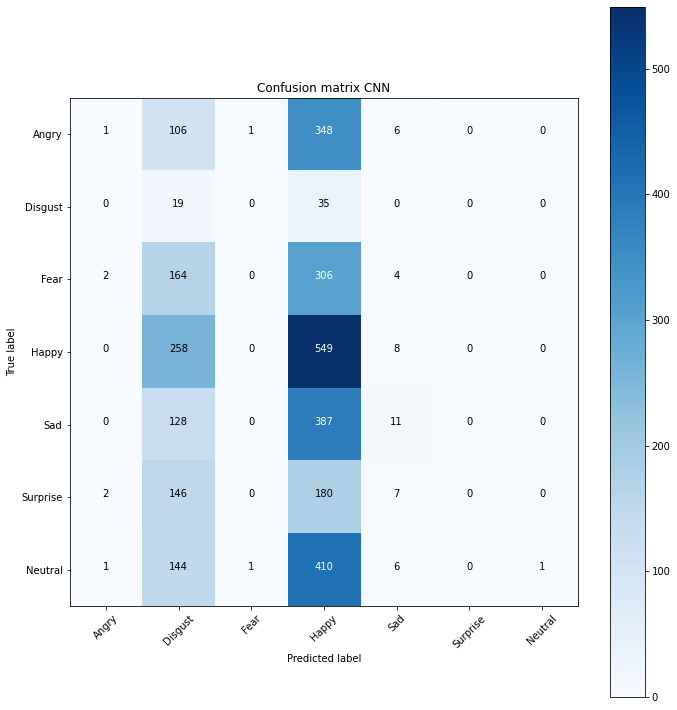

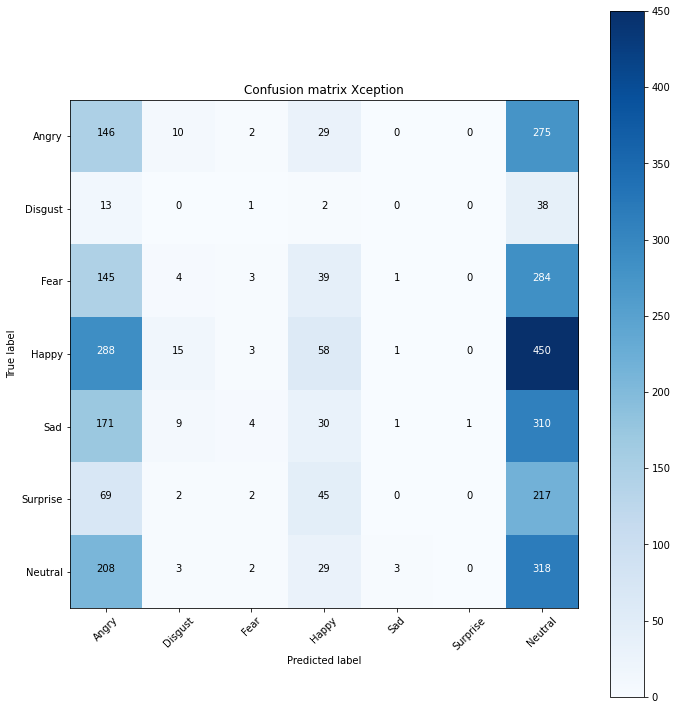

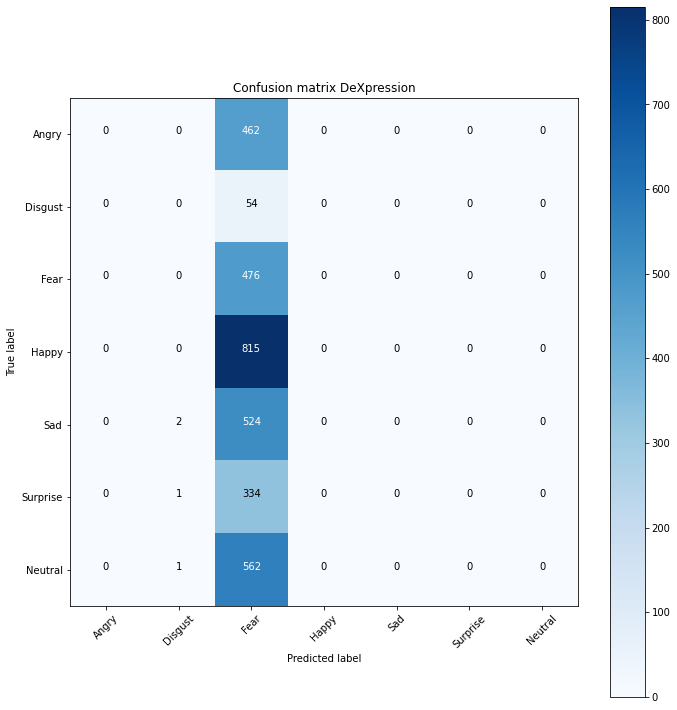

In [ ]:


import itertools
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure


for model,i in zip([CNN,xception,dexpression],[1,2,3]):
    fig = figure(figsize=(10, 10))
    
    ypred=model.predict(xtest)
    rounded_predections=np.argmax(ypred, axis=1)
    rounded_labels=np.argmax(ytest, axis=1)
    cm = confusion_matrix(rounded_labels, rounded_predections)
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    title='Confusion matrix '+model.name
    

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_'+model.name+'.png')
    plt.show()
    